# Test of the gradient model #

We are going to take the data from the simulation of the MSc project and compute the SFS terms for the non-relativistic case. We are going to directly calculate them and then we are going to do a priori test of the gradient model (Viganò et al, 2019).

In order to write the fluxes in terms of filtered primitive quantities, $\widetilde{P}$, we express these quantities as a function of filtered conserved quantities, $\overline{C}$: 

\begin{equation}
\begin{split}
        \widetilde{\rho} & = \overline{\rho} \\
        \widetilde{v}^i &  = \frac{\overline{N}^i}{\overline{\rho}} \\
        \widetilde{\epsilon} & = \frac{1}{\overline{\rho}}\big(\overline{U}-\frac{\overline{B}^2}{2}\big)-\frac{\widetilde{v}^2}{2} \\
        \widetilde{B}^i & = \overline{B}^i 
\end{split}
\end{equation}

In [79]:
import os 
import numpy as np
import math as m
import matplotlib.pyplot as plt
import h5py
#plt.style.use('seaborn-white')
from scipy.io import FortranFile

#READ DATA FUNCTION: 

def read_data(arxiu):
    
    """
    This function reads the data from
    the files, by choosing the file we 
    are interested to study.
    -Arguments: 
        arxiu: number of the file.
        
    """
    
    print('DATA FROM FILE:      ',arxiu)
    str1 = "/Users/miquelmiravet/Documents/University/Máster/Assignatures/Project/Tomek/mriquel-0file.dat" 
    ubi=str1.replace('file',arxiu)
    with FortranFile(ubi,'r','>u4') as f: 
        # read time
        time=f.read_reals(dtype='>f8')
        print ("time                     = ", time)
        # read dimensions of the grid
        nr = f.read_reals(dtype='>i4')[0]
        nphi = f.read_reals(dtype='>i4')[0]
        nz = f.read_reals(dtype='>i4')[0]
        print ("nr x nphi x nz           = ",nr," x ",nphi," x ",nz)
        # read grid arrays (1D)
        r = f.read_reals(dtype='>f8')
        phi = f.read_reals(dtype='>f8')
        z = f.read_reals(dtype='>f8')
        print ("len(r), len(phi), len(z) = ",len(r), len(phi), len(z))

        # read variables on the grid (3D arrays)
        Br = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("Br                       : ",Br.shape)
        Bphi = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("Bphi                     : ",Bphi.shape)
        Bz = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("Bz                       : ",Bz.shape)
        vr = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("vr                       : ",vr.shape)
        vphi = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("vphi                     : ",vphi.shape)
        vz = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("vz                       : ",vz.shape)
        rho = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("rho                      : ",rho.shape)
        Pgas = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("Pgas                     : ",Pgas.shape)
        phi2 = np.reshape(f.read_reals(dtype='>f8'),(nr,nphi,nz),'F')
        print ("phi                      : ",phi2.shape)
         
        
    return [time, r, phi, z, Br, Bphi, Bz, vr, vphi, vz, rho, Pgas, phi2] 
         
def splitting(arr,n):
    """
    Function that splits the array in order to 
    have a number of components proportional to n
    """
    frac = len(arr)/n
    if frac.is_integer() == False: 
        while True: 
            arr = np.delete(arr,len(arr)-1)
            frac_new = len(arr)/n
            if frac_new.is_integer() == True:
                break
    return arr

def averaging_subboxes_bis(var,n,m,r,phi,z): 
    """
    This function averages over (m,m,n) subboxes, 
    in order to determine the partial derivatives. 
    """
    
    #reshaping of the coordinate arrays into m/n subarrays of equal length
    r_split = r.reshape(m,int(len(r)/m))
    phi_split = phi.reshape(m,int(len(phi)/m))
    z_split = z.reshape(n,int(len(z)/n))
    
    var = np.array(var)
    varnew = np.zeros((len(r),len(phi),len(z)))
    
    #splitting of the variable arrays
    for i in range(0,len(r)):
        for j in range(0,len(phi)):
            varnew[i,j,:] = splitting(var[i,j,:],n)
        for k in range(0,len(z)):
            varnew[i,:,k] = splitting(var[i,:,k],m)
    for j in range(0,len(phi)):
        for k in range(0,len(z)):
            varnew[:,j,k] = splitting(var[:,j,k],m)
    
    #reshaping of the variable arrays into subarrays of equal length, corresponding to each sub-box.
    var_split = varnew.reshape(m,int(len(r)/m),m,int(len(phi)/m),n,int(len(z)/n))
    
    #AVERAGING PROCEDURE
    
    #differentials
    dr = r_split[0,1]-r_split[0,0]
    dphi = phi_split[0,1]-phi_split[0,0]
    dz = z_split[0,1]-z_split[0,0]
    
    varmean = np.zeros((m,m,n))
    
    #construction of the matrix that represents the integral differentials. It will be different for each sub-box
    dVmatrix = np.ones((m,int(len(r)/m),m,int(len(phi)/m),n,int(len(z)/n)))
    dVmatrixdef = np.zeros((m,int(len(r)/m),m,int(len(phi)/m),n,int(len(z)/n)))   
    for i in range(0,m):
        dV = r_split[i,:]*dr*dphi*dz
        for j in range(0,m):
            for k in range(0,n):
                for x in range(0,int(len(r)/m)):
                    dVmatrixdef[i,x,j,:,k,:] = dV[x]*dVmatrix[i,x,j,:,k,:]
    
    #volume of each sub-box                
    V = np.zeros((m,m,n))
    for i in range(0,m):
        for j in range(0,m):
            for k in range(0,n):
                V[i,j,k] = np.sum(dVmatrixdef[i,:,j,:,k,:])
    
    #averaging
    for i in range(0,m):
        for j in range(0,m):
            for k in range(0,n):
                varmean[i,j,k] = np.sum(dVmatrixdef[i,:,j,:,k,:]*var_split[i,:,j,:,k,:])/V[i,j,k] 
    return varmean

def averaging(var,n,m,r,phi,z): 
    """
    This function averages the whole box.  
    """
    
    #reshaping of the coordinate arrays into m/n subarrays of equal length
    r_split = r.reshape(m,int(len(r)/m))
    phi_split = phi.reshape(m,int(len(phi)/m))
    z_split = z.reshape(n,int(len(z)/n))
    r_subbox = np.zeros(m)
    for i in range(0,m):
        r_subbox[i] = (r_split[i,-1]+r_split[i,0])/2
    

    #AVERAGING PROCEDURE
    
    #differentials
    dr = r_split[1,0]-r_split[0,0]
    dphi = phi_split[1,0]-phi_split[0,0]
    dz = z_split[1,0]-z_split[0,0]
    
    
    #construction of the matrix that represents the integral differentials. It will be different for each sub-box
    dVmatrix = np.ones((m,m,n))
    dVmatrixdef = np.zeros((m,m,n))   
    
    dV = r_subbox[:]*dr*dphi*dz
    for x in range(0,m):
        dVmatrixdef[x,:,:] = dV[x]*dVmatrix[x,:,:]
    
    #volume                
    V = np.sum(dVmatrixdef)
    
    #averaging
    varmean = np.sum(dVmatrixdef*var)/V 
    
    return varmean

def sfs_tensors_theo(r,phi,z,n,m,v,B,press,U,rho,delta,N):
    """
    Construction of the flux terms. Use of the averaging 
    function to get the SFS tensors. 
    """

    #flux terms
    T = np.zeros((3,3,len(r),len(phi),len(z)))
    S = np.zeros((3,len(r), len(phi), len(z)))
    M = np.zeros((3,3,len(r), len(phi), len(z)))
    
    for i in range(0,3):
        S[i,:,:,:] = (U[:,:,:]+press[:,:,:]+0.5*(B[0,:,:,:]**2+B[1,:,:,:]**2+B[2,:,:,:]**2))*v[i,:,:,:]-(v[0,:,:,:]*B[0,:,:,:]+v[1,:,:,:]*B[1,:,:,:]+v[2,:,:,:]*B[2,:,:,:])*B[i,:,:,:]
        for j in range(0,3):
            T[j,i,:,:,:] = rho[:,:,:]*v[i,:,:,:]*v[j,:,:,:]-B[i,:,:,:]*B[j,:,:,:]+delta[j,i]*(press[:,:,:]+0.5*(B[0,:,:,:]**2+B[1,:,:,:]**2+B[2,:,:,:]**2))
            M[j,i,:,:,:] = v[i,:,:,:]*B[j,:,:,:]-B[i,:,:,:]*v[j,:,:,:]
    
    #splitting of the coordinate arrays to divide the box
    r = splitting(r,m)
    r = np.array(r)
    phi = splitting(phi,m)
    phi = np.array(phi)
    z = splitting(z,n)
    z = np.array(z)
    #determine averages:
    Nrmean = averaging_subboxes_bis(N[0,:,:,:],n,m,r,phi,z)
    Nphimean = averaging_subboxes_bis(N[1,:,:,:],n,m,r,phi,z)
    Nzmean = averaging_subboxes_bis(N[2,:,:,:],n,m,r,phi,z)
    Nmean = np.array([Nrmean,Nphimean,Nzmean])
    rhomean = averaging_subboxes_bis(rho,n,m,r,phi,z)
    vrmean = averaging_subboxes_bis(v[0,:,:,:],n,m,r,phi,z)
    vphimean = averaging_subboxes_bis(v[1,:,:,:],n,m,r,phi,z)
    vzmean = averaging_subboxes_bis(v[2,:,:,:],n,m,r,phi,z)
    vtilde = np.zeros((3,m,m,n))
    for i in range(0,3):
        vtilde[i,:,:,:] = Nmean[i,:,:,:]/rhomean[:,:,:] 
    bmean = np.array([averaging_subboxes_bis(B[0,:,:,:],n,m,r,phi,z),averaging_subboxes_bis(B[1,:,:,:],n,m,r,phi,z),averaging_subboxes_bis(B[2,:,:,:],n,m,r,phi,z)])
    Umean = averaging_subboxes_bis(U,n,m,r,phi,z)
    pmean = averaging_subboxes_bis(press,n,m,r,phi,z)
    
    #flux terms in terms of averaged/tilde variables: 
    Ttilde = np.zeros((3,3,m,m,n))
    Stilde = np.zeros((3,m,m,n))
    Mtilde = np.zeros((3,3,m,m,n))
    for i in range(0,3):
        Stilde[i,:,:,:] = (Umean[:,:,:]+pmean[:,:,:]+0.5*(bmean[0,:,:,:]**2+bmean[1,:,:,:]**2+bmean[2,:,:,:]**2))*vtilde[i,:,:,:]-(vtilde[0,:,:,:]*bmean[0,:,:,:]+vtilde[1,:,:,:]*bmean[1,:,:,:]+vtilde[2,:,:,:]*bmean[2,:,:,:])*bmean[i,:,:,:]
        for j in range(0,3):
            Ttilde[j,i,:,:,:] = rhomean[:,:,:]*vtilde[i,:,:,:]*vtilde[j,:,:,:]-bmean[i,:,:,:]*bmean[j,:,:,:]+delta[j,i]*(pmean[:,:,:]+0.5*(bmean[0,:,:,:]**2+bmean[1,:,:,:]**2+bmean[2,:,:,:]**2))
            Mtilde[j,i,:,:,:] = bmean[j,:,:,:]*vtilde[i,:,:,:]-vtilde[j,:,:,:]*bmean[i,:,:,:]
    
    #averaged flux terms
    
    Tmean = np.zeros((3,3,m,m,n))
    Smean = np.zeros((3,m,m,n))
    Mmean = np.zeros((3,3,m,m,n))
    for i in range(0,3):
        Smean[i,:,:,:] = averaging_subboxes_bis(S[i],n,m,r,phi,z)
        for j in range(0,3):
            Tmean[i,j,:,:,:] = averaging_subboxes_bis(T[i,j],n,m,r,phi,z)
            Mmean[i,j,:,:,:] = averaging_subboxes_bis(M[i,j],n,m,r,phi,z)
    
    #SFS tensors
    
    tau_T = Ttilde-Tmean
    tau_S = Stilde-Smean
    tau_M = Mtilde-Mmean

    return [tau_T, tau_S, tau_M]    

def gradients_bis(varmean,n,m,r,phi,z):
    """
    Determination of the gradient by using the finite difference method. 
    In order to do it, we need to average the variables over different sub-boxes.
    At the end, we average the gradients over the whole box in order to get a single value.
    """
     
    r_split = r.reshape(m,int(len(r)/m))
    phi_split = phi.reshape(m,int(len(phi)/m))
    z_split = z.reshape(n,int(len(z)/n))
    #print('r filter:', r_split[1,0]-r_split[0,0])
    #print('phi filter:', phi_split[1,0]-phi_split[0,0])
    #print('z filter:', z_split[1,0]-z_split[0,0])
     
    #differentials for the whole box averaging
    dr = r_split[1,0]-r_split[0,0]
    dphi = phi_split[1,0]-phi_split[0,0]
    dz = z_split[1,0]-z_split[0,0]

    #finite difference method
    dvardr = np.zeros((m,m,n))
    dvardphi = np.zeros((m,m,n))
    dvardz = np.zeros((m,m,n))
    
    
    for i in range(0,m):
        for j in range(0,m):
            for k in range(0,n-2):
                dvardz[i,j,k+1] = (varmean[i,j,k+2]-varmean[i,j,k])/(2*dz)
        for j in range(0,n):
            for k in range(0,m-2):
                dvardr[k+1,i,j] = (varmean[k+2,i,j]-varmean[k,i,j])/(2*dr)
                dvardphi[i,k+1,j] = (varmean[i,k+2,j]-varmean[i,k,j])/(2*dphi)
                
    for i in range(0,m):
        for j in range(0,m):
            dvardz[i,j,0] = (varmean[i,j,1]-varmean[i,j,0])/dz
            dvardz[i,j,n-1] = (varmean[i,j,n-1]-varmean[i,j,n-2])/dz
        for j in range(0,n):
            dvardr[0,i,j] = (varmean[1,i,j]-varmean[0,i,j])/dr
            dvardr[m-1,i,j] = (varmean[m-1,i,j]-varmean[m-2,i,j])/dr
            dvardphi[i,0,j] = (varmean[i,1,j]-varmean[i,0,j])/dphi
            dvardphi[i,m-1,j] = (varmean[i,m-1,j]-varmean[i,m-2,j])/dphi
 
    #GRADIENT: 
    
    #second component of the gradient : we have to divide by r (medium value in each sub-box)
    dvardphir = np.zeros((m,m,n))
    for i in range(0,m):
        dvardphir[i,:,:] = dvardphi[i,:,:]/((r_split[i,-1]+r_split[i,0])*0.5)
    
    grad = np.zeros((3,m,m,n)) 
    grad[0,:,:,:] = dvardr
    grad[1,:,:,:] = dvardphir
    grad[2,:,:,:] = dvardz
        
    return grad

def sfs_tensors_gradient(Sf,r,phi,z,n,m,B,v,rho,press,U,N,delta):
    """
    This function constructs the different SFS dictated
    by the gradient model. 
    """
    
    # chi = filter_size^2/24
    dr = r[1]-r[0]
    chi = ((Sf*dr)**2)/24
    
    #splitting of the coordinate arrays to divide the box
    r = splitting(r,m)
    r = np.array(r)
    phi = splitting(phi,m)
    phi = np.array(phi)
    z = splitting(z,n)
    z = np.array(z)
    
    #mean and tilde variables on which gradient will be applied
    
    Nrmean = averaging_subboxes_bis(N[0,:,:,:],n,m,r,phi,z)
    Nphimean = averaging_subboxes_bis(N[1,:,:,:],n,m,r,phi,z)
    Nzmean = averaging_subboxes_bis(N[2,:,:,:],n,m,r,phi,z)
    Nmean = np.array([Nrmean,Nphimean,Nzmean])
    rhomean = averaging_subboxes_bis(rho,n,m,r,phi,z)
    vrmean = averaging_subboxes_bis(v[0,:,:,:],n,m,r,phi,z)
    vphimean = averaging_subboxes_bis(v[1,:,:,:],n,m,r,phi,z)
    vzmean = averaging_subboxes_bis(v[2,:,:,:],n,m,r,phi,z)
    vtilde = np.zeros((3,m,m,n))
    for i in range(0,3):
        vtilde[i,:,:,:] = Nmean[i,:,:,:]/rhomean[:,:,:] 
    bmean = np.array([averaging_subboxes_bis(B[0,:,:,:],n,m,r,phi,z),averaging_subboxes_bis(B[1,:,:,:],n,m,r,phi,z),averaging_subboxes_bis(B[2,:,:,:],n,m,r,phi,z)])
    Umean = averaging_subboxes_bis(U,n,m,r,phi,z)
    pmean = averaging_subboxes_bis(press,n,m,r,phi,z)
    epstilde = Umean/rhomean-0.5*(vtilde[0]**2+vtilde[1]**2+vtilde[2]**2)-0.5*(bmean[0]**2+bmean[1]**2+bmean[2]**2)/rhomean
    phitilde = Umean+pmean+0.5*(bmean[0]**2+bmean[1]**2+bmean[2]**2)
    dpdeps = (gammat-1)*rhomean
    dpdrho = kappa*gamma1*rhomean**(gamma1-1)+(gammat-1)*(epstilde-kappa*gamma1/(gamma1-1)*rhomean**(gamma1-1))
    

    #gradients
    vtildegrad = np.zeros((3,3,m,m,n))
    for i in range(0,3):
        vtildegrad[i,:,:,:,:] = gradients_bis(vtilde[i,:,:,:],n,m,r,phi,z)
        
    bmeangrad = np.zeros((3,3,m,m,n))
    for i in range(0,3):        
        bmeangrad[i,:,:,:,:] = gradients_bis(bmean[i,:,:,:],n,m,r,phi,z)
    
    dpdrhograd = gradients_bis(dpdrho,n,m,r,phi,z)
    dpdepsgrad = gradients_bis(dpdeps,n,m,r,phi,z)
    rhomeangrad = gradients_bis(rhomean,n,m,r,phi,z)
    epstildegrad = gradients_bis(epstilde,n,m,r,phi,z)
    phitildegrad = gradients_bis(phitilde,n,m,r,phi,z)
    vbgrad = gradients_bis(vtilde[0]*bmean[0]+vtilde[1]*bmean[1]+vtilde[2]*bmean[2],n,m,r,phi,z) #gradient of the scalar product
              
    #SFS tensors                  
                      
    tau_kin = np.zeros((3,3,m,m,n))
    tau_mag = np.zeros((3,3,m,m,n))
    tau_ener = np.zeros((3,m,m,n))
    tau_ind = np.zeros((3,3,m,m,n))
    tau_pres = np.zeros((m,m,n))
    

    for x in range(0,m):
        for y in range(0,m):
            for z in range(0,n):
                for i in range(0,3):
                    tau_ener[i,x,y,z] = -2*chi*(np.sum(phitildegrad[:,x,y,z]*vtildegrad[i,:,x,y,z])+(np.sum((bmean[i,x,y,z]*np.sum(bmean[:,x,y,z]*vtildegrad[:,:,x,y,z], axis = 0))*rhomeangrad[:,x,y,z])-np.sum((phitilde[x,y,z]*vtildegrad[i,:,x,y,z])*rhomeangrad[:,x,y,z]))/rhomean[x,y,z]-bmean[i,x,y,z]*(bmeangrad[0,0,x,y,z]*vtildegrad[0,0,x,y,z]+bmeangrad[1,1,x,y,z]*vtildegrad[1,1,x,y,z]+bmeangrad[2,2,x,y,z]*vtildegrad[2,2,x,y,z])-np.sum(vbgrad[:,x,y,z]*bmeangrad[i,:,x,y,z]))
                    for j in range(0,3):
                        tau_kin[j,i,x,y,z] = -2*chi*rhomean[x,y,z]*np.sum(vtildegrad[i,:,x,y,z]*vtildegrad[j,:,x,y,z])
                        tau_mag[j,i,x,y,z] = -2*chi*np.sum(bmeangrad[i,:,x,y,z]*bmeangrad[j,:,x,y,z])
                        tau_ind[j,i,x,y,z] = -2*chi*(np.sum(vtildegrad[i,:,x,y,z]*bmeangrad[j,:,x,y,z])-np.sum(vtildegrad[j,:,x,y,z]*bmeangrad[i,:,x,y,z])+(bmean[i,x,y,z]*np.sum(vtildegrad[j,:,x,y,z]*rhomeangrad[:,x,y,z])-bmean[j,x,y,z]*np.sum(vtildegrad[i,:,x,y,z]*rhomeangrad[:,x,y,z]))/rhomean[x,y,z])
    
                tau_pres[x,y,z] = -chi*(np.sum(dpdrhograd[:,x,y,z]*rhomeangrad[:,x,y,z])+np.sum(dpdepsgrad[:,x,y,z]*epstildegrad[:,x,y,z])-2/rhomean[x,y,z]*dpdeps[x,y,z]*np.sum(rhomeangrad[:,x,y,z]*epstildegrad[:,x,y,z])+bmeangrad[0,0,x,y,z]**2+bmeangrad[1,1,x,y,z]**2+bmeangrad[2,2,x,y,z]**2-dpdeps[x,y,z]/rhomean[x,y,z]*(rhomean[x,y,z]*(vtildegrad[0,0,x,y,z]**2+vtildegrad[1,1,x,y,z]**2+vtildegrad[2,2,x,y,z]**2)+bmeangrad[0,0,x,y,z]**2+bmeangrad[1,1,x,y,z]**2+bmeangrad[2,2,x,y,z]**2))
    
    tau_T = np.zeros((3,3,m,m,n))
    tau_S = np.zeros((3,m,m,n))
    tau_M = tau_ind
    for x in range(0,m):
        for y in range(0,m): 
            for z in range(0,n):
                tau_T[:,:,x,y,z] = tau_kin[:,:,x,y,z]-tau_mag[:,:,x,y,z]+delta[:,:]*tau_pres[x,y,z]
                tau_S[:,x,y,z] = tau_ener[:,x,y,z]+vtilde[:,x,y,z]*tau_pres[x,y,z]
                
    return [tau_T, tau_S, tau_M]


In [289]:
#PROVA

listvar = read_data('200')
r = listvar[1]
phi = listvar[2]
z = listvar[3]
B = [listvar[4],listvar[5],listvar[6]]
B = np.array(B)
v = [listvar[7],listvar[8],listvar[9]] 
v = np.array(v)
rho = listvar[10]
N = np.zeros((3,len(r),len(phi),len(z)))
press = listvar[11]

#to constant arrays
Bctt = B[0,0,0,0]
vctt = v[0,0,0,0]
rhoctt = rho[0,0,0]
pressctt = press[0,0,0]

for i in range(0,len(r)):
    for j in range(0,len(phi)):
        for k in range(0,len(z)): 
            B[:,i,j,k] = Bctt
            v[:,i,j,k] = vctt
            rho[i,j,k] = rhoctt
            press[i,j,k] = pressctt

delta = np.identity(3) #kronecker delta 
kappacgs = 4.8974894*10**(14) 
gamma1 = 1.31
gammat = 2.5 #es lo que sale en la tesis (martin dijo 2.5)
kappa = kappacgs*8.26110825*10**(-50)/((7.42471382*10**(-29))**(gamma1))

pressp = kappa*rho**(gamma1)
ep = kappa/(gamma1-1)*rho**(gamma1-1) 
presst = press-pressp
et = presst/(rho*(gammat-1)) 
eps = (ep+et)
    
    
U = (rho*eps+rho*0.5*(v[0,:,:,:]**2+v[1,:,:,:]**2+v[2,:,:,:]**2)+0.5*(B[0,:,:,:]**2+B[1,:,:,:]**2+B[2,:,:,:]**2))*8.26110825*10**(-50) #energy density
rho = rho*7.42471382*10**(-29)
press = press*8.26110825*10**(-50)
v = v*3.33564095*10**(-11)
eps = eps*1.11265006*10**(-21)
B = B*1/(4*3.141592653589793)**(0.5)*2.874214371*10**(-25)
for i in range(0,3):
    N[i,:,:,:] = rho[:,:,:]*v[i,:,:,:]

n = 3
m = 10
r = splitting(r,m)
r = np.array(r)
phi = splitting(phi,m)
phi = np.array(phi)
z = splitting(z,n)
z = np.array(z)

# TEST
var = U
aver = averaging_subboxes_bis(var,n,m,r,phi,z)
grad = gradients_bis(aver,n,m,r,phi,z)
print('VARIABLE:', var)
print('AVERAGE:', aver[:,0,0])
print('GRADIENT:', grad[0])

r = listvar[1]
phi = listvar[2]
z = listvar[3]

taus_grad = sfs_tensors_gradient(r,phi,z,n,m,B,v,rho,press,U,N,delta)
taus_teo = sfs_tensors_theo(r,phi,z,n,m,v,B,press,U,rho,delta,N)
tau_Tgrad = taus_grad[0]
print('tau:',tau_Tgrad[0,0])




DATA FROM FILE:       200
time                     =  [0.002]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                     :  (100, 100, 34)
phi                      :  (100, 100, 34)
VARIABLE: [[[1.12553953e-17 1.12553953e-17 1.12553953e-17 ... 1.12553953e-17
   1.12553953e-17 1.12553953e-17]
  [1.12553953e-17 1.12553953e-17 1.12553953e-17 ... 1.12553953e-17
   1.12553953e-17 1.12553953e-17]
  [1.12553953e-17 1.12553953e-17 1.12553953e-17 ... 1.12553953e-17
   1.12553953e-17 1.12553953e-17]
  ...
  [1.12553953e-17 1.12553953e-17 1.12553953e-17 ... 1.12553953e-17
   1.12553953e-17 1.12553953e-17]
  [1.12553953e-17 1.12553953e-17 1.12553953e-

tau: [[[ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]
  [ 1.08755074e-54  1.08755074e-54  1.08755074e-54]]

 [[ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2.13822613e-50  2.13822613e-50  2.13822613e-50]
  [ 2

In [290]:
listvar = read_data('200')
r = listvar[1]
phi = listvar[2]
z = listvar[3]
B = [listvar[4],listvar[5],listvar[6]]
B = np.array(B)
v = [listvar[7],listvar[8],listvar[9]] 
v = np.array(v)
rho = listvar[10]
N = np.zeros((3,len(r),len(phi),len(z)))
press = listvar[11]

#to constant arrays
Bctt = B[0,0,0,0]
vctt = v[0,0,0,0]
rhoctt = rho[0,0,0]
pressctt = press[0,0,0]
Brgrad = np.zeros((len(r),len(phi),len(z)))
for i in range(0,len(r)):
    for j in range(0,len(phi)):
        for k in range(0,len(z)): 
            B[0,i,j,k] = (Bctt/100)+(Bctt)*np.cos(20.*r[i])
            Brgrad[i,j,k] = -20.*Bctt*np.sin(20.*r[i])
            B[1,i,j,k] = Bctt
            B[2,i,j,k] = Bctt
            v[:,i,j,k] = vctt
            rho[i,j,k] = rhoctt
            press[i,j,k] = pressctt
r = splitting(r,m)
r = np.array(r)
phi = splitting(phi,m)
phi = np.array(phi)
z = splitting(z,n)
z = np.array(z)
Brgradav = averaging_subboxes_bis(Brgrad,n,m,r,phi,z)
Bravbis = averaging_subboxes_bis(B[0],n,m,r,phi,z)
Brgradavbis = gradients_bis(Bravbis,n,m,r,phi,z)
print('GRADIENT COMPARISON:',Brgradavbis[0]/Brgradav)


DATA FROM FILE:       200
time                     =  [0.002]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                     :  (100, 100, 34)
phi                      :  (100, 100, 34)
GRADIENT COMPARISON: [[[-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.64802879e-07 -3.64802879e-07]
  [-3.64802879e-07 -3.648028

## SGS tensors for all times ##
Now, we can determine the tensors for every time in the simulation and build arrays that contain these values. 

In [134]:
#TIME EVOLUTION 

t = np.linspace(0,6,61)

#sub-boxes

Sf = 10

var = read_data('000')
r = var[1]
phi = var[2]
z = var[3]

lenr = r[-1]-r[0]
dr = r[1]-r[0]
lenphi=(phi[-1]-phi[0])
dphi=phi[1]-phi[0]
lenz = z[-1]-z[0]
dz=z[1]-z[0]

n = int(lenz/(Sf*dz))
m = int(lenr/(Sf*dr))

tau_T_theo = np.zeros((61,3,3,m,m,n))
tau_S_theo = np.zeros((61,3,m,m,n))
tau_M_theo = np.zeros((61,3,3,m,m,n))
tau_T_grad = np.zeros((61,3,3,m,m,n))
tau_S_grad = np.zeros((61,3,m,m,n))
tau_M_grad = np.zeros((61,3,3,m,m,n))
delta = np.identity(3) #kronecker delta 
kappacgs = 4.8974894*10**(14) 
gamma1 = 1.31
gammat = 1.5 #es lo que sale en la tesis (martin dijo 2.5)
kappa = kappacgs*8.26110825*10**(-50)/((7.42471382*10**(-29))**(gamma1))


for x in range(0,61):
    arx = format(10*x, "03")
    listvar = read_data(arx)
    B = [listvar[4],listvar[5],listvar[6]]
    B = np.array(B)*2.874214371*10**(-25)/((4*3.141592653589793)**(0.5))     
    v = [listvar[7],listvar[8],listvar[9]] 
    v = np.array(v)*3.33564095*10**(-11)
    rho = listvar[10]*7.42471382*10**(-29)
    N = np.zeros((3,len(r),len(phi),len(z)))
    press = listvar[11]*8.26110825*10**(-50)
      
        
#let's determine the specific internal energy

    pressp = kappa*rho**(gamma1)
    ep = kappa/(gamma1-1)*rho**(gamma1-1) 
    presst = press-pressp
    et = presst/(rho*(gammat-1)) 
    eps = (ep+et)
    
    
    U = rho*eps+rho*0.5*(v[0]**2+v[1]**2+v[2]**2)+0.5*(B[0]**2+B[1]**2+B[2]**2) #energy density

    for i in range(0,3):
        N[i] = rho*v[i]

    taustheo = sfs_tensors_theo(r,phi,z,n,m,v,B,press,U,rho,delta,N)
    
    tau_T_theo[x] = taustheo[0]
    tau_S_theo[x] = taustheo[1]
    tau_M_theo[x] = taustheo[2]


    tausgrad = sfs_tensors_gradient(Sf,r,phi,z,n,m,B,v,rho,press,U,N,delta)
    tau_T_grad[x] = tausgrad[0]
    tau_S_grad[x] = tausgrad[1]
    tau_M_grad[x] = tausgrad[2]



DATA FROM FILE:       000
time                     =  [0.]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                     :  (100, 100, 34)
phi                      :  (100, 100, 34)
DATA FROM FILE:       000
time                     =  [0.]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                  

DATA FROM FILE:       150
time                     =  [0.0015]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                     :  (100, 100, 34)
phi                      :  (100, 100, 34)
DATA FROM FILE:       160
time                     =  [0.0016]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas          

DATA FROM FILE:       310
time                     =  [0.0031]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                     :  (100, 100, 34)
phi                      :  (100, 100, 34)
DATA FROM FILE:       320
time                     =  [0.0032]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas          

DATA FROM FILE:       470
time                     =  [0.0047]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas                     :  (100, 100, 34)
phi                      :  (100, 100, 34)
DATA FROM FILE:       480
time                     =  [0.0048]
nr x nphi x nz           =  100  x  100  x  34
len(r), len(phi), len(z) =  100 100 34
Br                       :  (100, 100, 34)
Bphi                     :  (100, 100, 34)
Bz                       :  (100, 100, 34)
vr                       :  (100, 100, 34)
vphi                     :  (100, 100, 34)
vz                       :  (100, 100, 34)
rho                      :  (100, 100, 34)
Pgas          

In [135]:
path = str(os.getcwd())+'/Sf_'+str(Sf)
try:
    os.mkdir(path)
except OSError as error:
    print(error)
    
new_folder = path+'/FILES'
try:
    os.mkdir(new_folder)
except OSError as error:
    print(error)

new_plot= path+'/PLOTS'
try:
    os.mkdir(new_plot)
except OSError as error:
    print(error)

corr_path = path+'/Pearson-corr'
try:
    os.mkdir(corr_path)
except OSError as error:
    print(error)
    
cbest_path = path+'/C_best'
try:
    os.mkdir(cbest_path)
except OSError as error:
    print(error)

[Errno 17] File exists: '/Users/miquelmiravet/Documents/University/DOCTORADO 2020-21/sub-grid models/Sf_10'
[Errno 17] File exists: '/Users/miquelmiravet/Documents/University/DOCTORADO 2020-21/sub-grid models/Sf_10/FILES'
[Errno 17] File exists: '/Users/miquelmiravet/Documents/University/DOCTORADO 2020-21/sub-grid models/Sf_10/PLOTS'
[Errno 17] File exists: '/Users/miquelmiravet/Documents/University/DOCTORADO 2020-21/sub-grid models/Sf_10/Pearson-corr'
[Errno 17] File exists: '/Users/miquelmiravet/Documents/University/DOCTORADO 2020-21/sub-grid models/Sf_10/C_best'


## Files ##
We can now create files that contain the values of the SFS tensors. 

In [136]:
#FILE CREATION 

import csv 

with open(new_folder+'/tauTteo.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for a in range(0,m):
        for b in range(0,m):
            for c in range(0,n):
                cols = zip(tau_T_theo[:,0,0,a,b,c],tau_T_theo[:,0,1,a,b,c],tau_T_theo[:,0,2,a,b,c],tau_T_theo[:,1,1,a,b,c],tau_T_theo[:,1,2,a,b,c],tau_T_theo[:,2,2,a,b,c])
                writer.writerow(str(a)+','+str(b)+','+str(c))
                writer.writerows(cols)
f.close()

with open(new_folder+'/tauTgrad.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for a in range(0,m):
        for b in range(0,m):
            for c in range(0,n):
                cols = zip(tau_T_grad[:,0,0,a,b,c],tau_T_grad[:,0,1,a,b,c],tau_T_grad[:,0,2,a,b,c],tau_T_grad[:,1,1,a,b,c],tau_T_grad[:,1,2,a,b,c],tau_T_grad[:,2,2,a,b,c])
                writer.writerow(str(a)+','+str(b)+','+str(c))
                writer.writerows(cols)
f.close()
              
with open(new_folder+'/tauSteo.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for a in range(0,m):
        for b in range(0,m):
            for c in range(0,n):
                cols = zip(tau_S_theo[:,0,a,b,c],tau_S_theo[:,1,a,b,c],tau_S_theo[:,2,a,b,c])
                writer.writerow(str(a)+','+str(b)+','+str(c))
                writer.writerows(cols)
f.close()
              
with open(new_folder+'/tauSgrad.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for a in range(0,m):
        for b in range(0,m):
            for c in range(0,n):
                cols = zip(tau_S_grad[:,0,a,b,c],tau_S_grad[:,1,a,b,c],tau_S_grad[:,2,a,b,c])
                writer.writerow(str(a)+','+str(b)+','+str(c))
                writer.writerows(cols)
f.close()
              
with open(new_folder+'/tauMteo.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for a in range(0,m):
        for b in range(0,m):
            for c in range(0,n):
                cols = zip(tau_M_theo[:,0,1,a,b,c],tau_M_theo[:,0,2,a,b,c],tau_M_theo[:,1,2,a,b,c])
                writer.writerow(str(a)+','+str(b)+','+str(c))
                writer.writerows(cols)
f.close() 
    
with open(new_folder+'/tauMgrad.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for a in range(0,m):
        for b in range(0,m):
            for c in range(0,n):
                cols = zip(tau_M_grad[:,0,1,a,b,c],tau_M_grad[:,0,2,a,b,c],tau_M_grad[:,1,2,a,b,c])
                writer.writerow(str(a)+','+str(b)+','+str(c))
                writer.writerows(cols)
f.close()          

## Plots ##
Here we can build the plots for each sub-box by choosing it (a,b,c values). 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


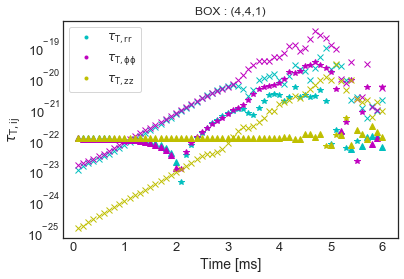

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


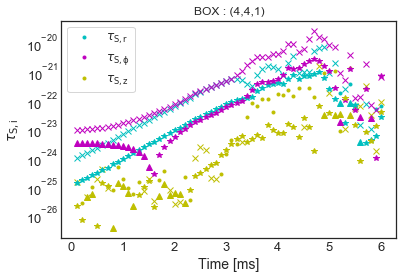

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [137]:
#PLOTS

t_plot = np.delete(t,0)
tau_T_theo_tplot = np.zeros((60,3,3,m,m,n))
tau_S_theo_tplot = np.zeros((60,3,m,m,n))
tau_M_theo_tplot = np.zeros((60,3,3,m,m,n))
tau_T_grad_tplot = np.zeros((60,3,3,m,m,n))
tau_S_grad_tplot = np.zeros((60,3,m,m,n))
tau_M_grad_tplot = np.zeros((60,3,3,m,m,n))
for x in range(0,m):
    for y in range(0,m):
        for z in range(0,n):
            for k in range(0,3):
                tau_S_theo_tplot[:,k,x,y,z] = np.delete(tau_S_theo[:,k,x,y,z],0)
                tau_S_grad_tplot[:,k,x,y,z] = np.delete(tau_S_grad[:,k,x,y,z],0)
                for l in range(0,3):
                    tau_T_theo_tplot[:,k,l,x,y,z] = np.delete(tau_T_theo[:,k,l,x,y,z],0)
                    tau_M_theo_tplot[:,k,l,x,y,z] = np.delete(tau_M_theo[:,k,l,x,y,z],0)
                    tau_T_grad_tplot[:,k,l,x,y,z] = np.delete(tau_T_grad[:,k,l,x,y,z],0)
                    tau_M_grad_tplot[:,k,l,x,y,z] = np.delete(tau_M_grad[:,k,l,x,y,z],0)
        
a = 4
b = 4
c = 1
fig, ax = plt.subplots()
ax.plot(t_plot,tau_T_theo_tplot[:,0,0,a,b,c], linestyle='None', marker='.', color ='c',label = r'$\tau_{\rm{T},rr}$')
ax.plot(t_plot,-tau_T_theo_tplot[:,0,0,a,b,c], linestyle='None', marker='x', color ='c')
ax.plot(t_plot,tau_T_grad_tplot[:,0,0,a,b,c], linestyle='None', marker='^', color ='c')
ax.plot(t_plot,-tau_T_grad_tplot[:,0,0,a,b,c], linestyle='None', marker='*', color ='c')
ax.plot(t_plot,tau_T_theo_tplot[:,1,1,a,b,c], linestyle='None', marker='.', color ='m',label = r'$\tau_{\rm{T},\phi\phi}$')
ax.plot(t_plot,-tau_T_theo_tplot[:,1,1,a,b,c], linestyle='None', marker='x', color ='m')
ax.plot(t_plot,tau_T_grad_tplot[:,1,1,a,b,c], linestyle='None', marker='^', color ='m')
ax.plot(t_plot,-tau_T_grad_tplot[:,1,1,a,b,c], linestyle='None', marker='*', color ='m')
ax.plot(t_plot,tau_T_theo_tplot[:,2,2,a,b,c], linestyle='None', marker='.', color ='y',label = r'$\tau_{\rm{T},zz}$')
ax.plot(t_plot,-tau_T_theo_tplot[:,2,2,a,b,c], linestyle='None', marker='x', color ='y')
ax.plot(t_plot,tau_T_grad_tplot[:,2,2,a,b,c], linestyle='None', marker='^', color ='y')
ax.plot(t_plot,-tau_T_grad_tplot[:,2,2,a,b,c], linestyle='None', marker='*', color ='y')
plt.yscale('log')
plt.title('BOX : ('+str(a)+','+str(b)+','+str(c)+')')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$\tau_{\rm{T},ij}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
leg = ax.legend(loc = 'upper left', frameon = 'True', prop={"size":12})
plt.savefig(new_plot+'/Tdiagonal'+str(a)+str(b)+str(c)+'.eps',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots()
ax.plot(t_plot,tau_T_theo_tplot[:,0,1,a,b,c], linestyle='None', marker='.', color ='c',label = r'$\tau_{\rm{T},r\phi}$')
ax.plot(t_plot,-tau_T_theo_tplot[:,0,1,a,b,c], linestyle='None', marker='x', color ='c')
ax.plot(t_plot,tau_T_theo_tplot[:,0,2,a,b,c], linestyle='None', marker='.', color ='m',label = r'$\tau_{\rm{T},rz}$')
ax.plot(t_plot,-tau_T_theo_tplot[:,0,2,a,b,c], linestyle='None', marker='x', color ='m')
ax.plot(t_plot,tau_T_theo_tplot[:,1,2,a,b,c], linestyle='None', marker='.', color ='y',label = r'$\tau_{\rm{T},\phi z}$')
ax.plot(t_plot,-tau_T_theo_tplot[:,1,2,a,b,c], linestyle='None', marker='x', color ='y')
ax.plot(t_plot,tau_T_grad_tplot[:,0,1,a,b,c], linestyle='None', marker='^', color ='c')
ax.plot(t_plot,-tau_T_grad_tplot[:,0,1,a,b,c], linestyle='None', marker='*', color ='c')
ax.plot(t_plot,tau_T_grad_tplot[:,0,2,a,b,c], linestyle='None', marker='^', color ='m')
ax.plot(t_plot,-tau_T_grad_tplot[:,0,2,a,b,c], linestyle='None', marker='*', color ='m')
ax.plot(t_plot,tau_T_grad_tplot[:,1,2,a,b,c], linestyle='None', marker='^', color ='y')
ax.plot(t_plot,tau_T_grad_tplot[:,1,2,a,b,c], linestyle='None', marker='*', color ='y')
plt.yscale('log')
plt.title('BOX : ('+str(a)+','+str(b)+','+str(c)+')')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$\tau_{\rm{T},ij}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
leg = ax.legend(loc = 'upper left', frameon = 'True', prop={"size":12})
plt.savefig(new_plot+'/Tnondiagonal'+str(a)+str(b)+str(c)+'.eps',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots()
ax.plot(t_plot,tau_S_theo_tplot[:,0,a,b,c], linestyle='None', marker='.', color ='c',label = r'$\tau_{\rm{S},r}$')
ax.plot(t_plot,-tau_S_theo_tplot[:,0,a,b,c], linestyle='None', marker='x', color ='c')
ax.plot(t_plot,tau_S_theo_tplot[:,1,a,b,c], linestyle='None', marker='.', color ='m',label = r'$\tau_{\rm{S},\phi}$')
ax.plot(t_plot,-tau_S_theo_tplot[:,1,a,b,c], linestyle='None', marker='x', color ='m')
ax.plot(t_plot,tau_S_theo_tplot[:,2,a,b,c], linestyle='None', marker='.', color ='y',label = r'$\tau_{\rm{S},z}$')
ax.plot(t_plot,-tau_S_theo_tplot[:,2,a,b,c], linestyle='None', marker='x', color ='y')
ax.plot(t_plot,tau_S_grad_tplot[:,0,a,b,c], linestyle='None', marker='^', color ='c')
ax.plot(t_plot,-tau_S_grad_tplot[:,0,a,b,c], linestyle='None', marker='*', color ='c')
ax.plot(t_plot,tau_S_grad_tplot[:,1,a,b,c], linestyle='None', marker='^', color ='m')
ax.plot(t_plot,-tau_S_grad_tplot[:,1,a,b,c], linestyle='None', marker='*', color ='m')
ax.plot(t_plot,tau_S_grad_tplot[:,2,a,b,c], linestyle='None', marker='^', color ='y')
ax.plot(t_plot,-tau_S_grad_tplot[:,2,a,b,c], linestyle='None', marker='*', color ='y')
plt.yscale('log')
plt.title('BOX : ('+str(a)+','+str(b)+','+str(c)+')')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$\tau_{\rm{S},i}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
leg = ax.legend(loc = 'upper left', frameon = 'True', prop={"size":12})
plt.savefig(new_plot+'/S'+str(a)+str(b)+str(c)+'.eps',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots()
ax.plot(t_plot,tau_M_theo_tplot[:,0,1,a,b,c], linestyle='None', marker='.', color ='c',label = r'$\tau_{\rm{M},r\phi}$')
ax.plot(t_plot,-tau_M_theo_tplot[:,0,1,a,b,c], linestyle='None', marker='x', color ='c')
ax.plot(t_plot,tau_M_theo_tplot[:,0,2,a,b,c], linestyle='None', marker='.', color ='m',label = r'$\tau_{\rm{M},rz}$')
ax.plot(t_plot,-tau_M_theo_tplot[:,0,2,a,b,c], linestyle='None', marker='x', color ='m')
ax.plot(t_plot,tau_M_theo_tplot[:,1,2,a,b,c], linestyle='None', marker='.', color ='y',label = r'$\tau_{\rm{M},\phi z}$')
ax.plot(t_plot,-tau_M_theo_tplot[:,1,2,a,b,c], linestyle='None', marker='x', color ='y')
ax.plot(t_plot,tau_M_grad_tplot[:,0,1,a,b,c], linestyle='None', marker='^', color ='c')
ax.plot(t_plot,-tau_M_grad_tplot[:,0,1,a,b,c], linestyle='None', marker='*', color ='c')
ax.plot(t_plot,tau_M_grad_tplot[:,0,2,a,b,c], linestyle='None', marker='^', color ='m')
ax.plot(t_plot,-tau_M_grad_tplot[:,0,2,a,b,c], linestyle='None', marker='*', color ='m')
ax.plot(t_plot,tau_M_grad_tplot[:,1,2,a,b,c], linestyle='None', marker='^', color ='y')
ax.plot(t_plot,-tau_M_grad_tplot[:,1,2,a,b,c], linestyle='None', marker='*', color ='y')
plt.yscale('log')
plt.title('BOX : ('+str(a)+','+str(b)+','+str(c)+')')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$\tau_{\rm{M},ij}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
leg = ax.legend(loc = 'upper left', frameon = 'True', prop={"size":12})
plt.savefig(new_plot+'/M'+str(a)+str(b)+str(c)+'.eps',bbox_inches = 'tight')
plt.show()


## Pearson correlation coefficient and Cbest##
Now we can compute the Pearson correlation coefficient as done in the paper to check the correlation between the SFS and SGS tensors. We can do it for each component. We can also determine the $C_{best}$ parameter. 

In [138]:
from scipy.stats import pearsonr

corr_tauT = np.zeros((61,3,3))
corr_tauS = np.zeros((61,3))
corr_tauM = np.zeros((61,3,3))
tau_S_theo_corr = np.zeros((61,3,m*m*n))
tau_S_grad_corr = np.zeros((61,3,m*m*n))
tau_T_theo_corr = np.zeros((61,3,3,m*m*n))
tau_T_grad_corr = np.zeros((61,3,3,m*m*n))
tau_M_theo_corr = np.zeros((61,3,3,m*m*n))
tau_M_grad_corr = np.zeros((61,3,3,m*m*n))
for x in range(0,61):
    for i in range(0,3):
        tau_S_theo_corr[x,i,:] = tau_S_theo[x,i,:,:,:].reshape(m*m*n)
        tau_S_grad_corr[x,i,:] = tau_S_grad[x,i,:,:,:].reshape(m*m*n)
        for j in range(0,3):
            tau_T_theo_corr[x,i,j,:] = tau_T_theo[x,i,j,:,:,:].reshape(m*m*n)
            tau_T_grad_corr[x,i,j,:] = tau_T_grad[x,i,j,:,:,:].reshape(m*m*n)
            tau_M_theo_corr[x,i,j,:] = tau_M_theo[x,i,j,:,:,:].reshape(m*m*n)
            tau_M_grad_corr[x,i,j,:] = tau_M_grad[x,i,j,:,:,:].reshape(m*m*n)

corr_tauT_av = np.zeros(61)
corr_tauS_av = np.zeros(61)
corr_tauM_av = np.zeros(61)

for x in range(0,61):
    for i in range(0,3):
        corr_tauS[x,i], ps = pearsonr(tau_S_theo_corr[x,i,:],tau_S_grad_corr[x,i,:])
        for j in range(0,3):
            corr_tauT[x,i,j], pt = pearsonr(tau_T_theo_corr[x,i,j,:],tau_T_grad_corr[x,i,j,:])
            corr_tauM[x,i,j], pm = pearsonr(tau_M_theo_corr[x,i,j,:],tau_M_grad_corr[x,i,j,:])

    corr_tauT_av[x] = (corr_tauT[x,0,0]+corr_tauT[x,1,1]+corr_tauT[x,2,2]+corr_tauT[x,0,1]+corr_tauT[x,0,2]+corr_tauT[x,1,2])/6
    corr_tauM_av[x] = (corr_tauM[x,0,1]+corr_tauM[x,0,2]+corr_tauM[x,1,2])/3
    corr_tauS_av[x] = np.sum(corr_tauS[x,:])/3






/Users/miquelmiravet/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [139]:
#FILES FOR PEARSON COEFFICIENT

with open(corr_path+'/pearson_coeff.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    cols = zip(corr_tauT_av[:],corr_tauS_av[:],corr_tauM_av[:])
    writer.writerows(cols)   

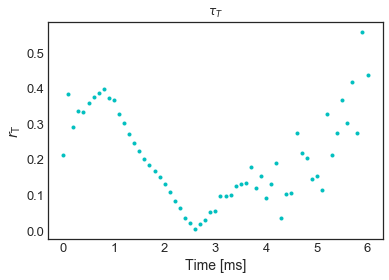

In [140]:
#PLOTS FOR PEARSON COEFFICIENT

fig, ax = plt.subplots()
ax.plot(t,abs(corr_tauT_av[:]), linestyle='None', marker='.', color ='c')
#plt.yscale('log')
plt.title(r'$\tau_T$')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$r_{\rm{T}}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
plt.savefig(corr_path+'/r_tauT.eps')
plt.show()

fig, ax = plt.subplots()
ax.plot(t,abs(corr_tauS_av[:]), linestyle='None', marker='.', color ='c')
#plt.yscale('log')
plt.title(r'$\tau_S$')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$r_{\rm{S}}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
plt.savefig(corr_path+'/r_tauS.eps')
plt.show()

fig, ax = plt.subplots()
ax.plot(t,abs(corr_tauM_av[:]), linestyle='None', marker='.', color ='c')
#plt.yscale('log')
plt.title(r'$\tau_M$')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$r_{\rm{M}}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
plt.savefig(corr_path+'/r_tauM.eps')
plt.show()


In [141]:
#Cbest parameter


c_tauT = np.zeros((61,3,3))
c_tauS = np.zeros((61,3))
c_tauM = np.zeros((61,3,3))
c_tauT_av = np.zeros(61)
c_tauM_av = np.zeros(61)
c_tauS_av = np.zeros(61)

for x in range(0,61):
    for i in range(0,3):
        c_tauS[x,i] = np.sum(tau_S_theo[x,i,:,:,:]*tau_S_grad[x,i,:,:,:])/np.sum(tau_S_grad[x,i,:,:,:]**2)
        for j in range(0,3):
            c_tauT[x,i,j] = np.sum(tau_T_theo[x,i,j,:,:,:]*tau_T_grad[x,i,j,:,:,:])/np.sum(tau_T_grad[x,i,j,:,:,:]**2)
            c_tauM[x,i,j] = np.sum(tau_M_theo[x,i,j,:,:,:]*tau_M_grad[x,i,j,:,:,:])/np.sum(tau_M_grad[x,i,j,:,:,:]**2)
    
    c_tauT_av[x] = (c_tauT[x,0,0]+c_tauT[x,1,1]+c_tauT[x,2,2]+c_tauT[x,0,1]+c_tauT[x,0,2]+c_tauT[x,1,2])/6
    c_tauM_av[x] = (c_tauM[x,0,2]+c_tauM[x,0,1]+c_tauM[x,1,2])/3
    c_tauS_av[x] = np.sum(c_tauS[x,:])/3


/Users/miquelmiravet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [142]:
with open(cbest_path+'/cbest_param.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    cols = zip(c_tauT_av[:],c_tauS_av[:],c_tauM_av[:])
    writer.writerows(cols) 

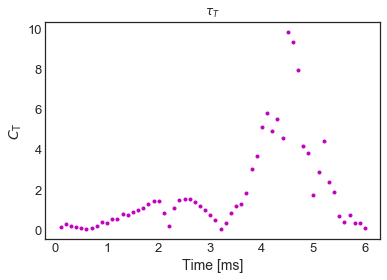

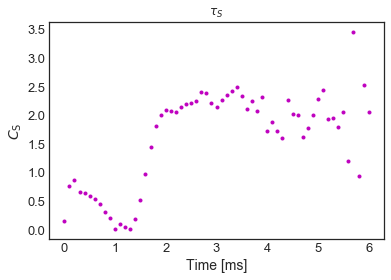

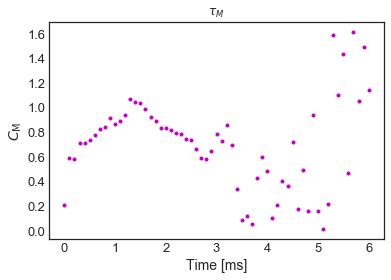

In [143]:
fig, ax = plt.subplots()
c_tauT_av_plot = np.delete(c_tauT_av,0)
ax.plot(t_plot,abs(c_tauT_av_plot[:]), linestyle='None', marker='.', color ='m')
#plt.yscale('log')
plt.title(r'$\tau_T$')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$C_{\rm{T}}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
plt.savefig(cbest_path+'/cbest_tauT.eps')
plt.show()

fig, ax = plt.subplots()
ax.plot(t,abs(c_tauS_av[:]), linestyle='None', marker='.', color ='m')
#plt.yscale('log')
plt.title(r'$\tau_S$')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$C_{\rm{S}}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
plt.savefig(cbest_path+'/cbest_tauS.eps')
plt.show()

fig, ax = plt.subplots()
ax.plot(t,abs(c_tauM_av[:]), linestyle='None', marker='.', color ='m')
#plt.yscale('log')
plt.title(r'$\tau_M$')
plt.xlabel('Time [ms]', fontsize = '14')
plt.ylabel(r'$C_{\rm{M}}$', fontsize = '14')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.grid()
plt.savefig(cbest_path+'/cbest_tauM.eps')
plt.show()
